In [11]:
import io
import logging
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML, display, Image as IImage

from rekognition_objects import (
    RekognitionFace, RekognitionCelebrity, RekognitionLabel,
    RekognitionModerationLabel, RekognitionText, show_bounding_boxes, show_polygons)

logger = logging.getLogger(__name__)

In [4]:
def show_bounding_boxes(image_bytes, box_sets, colors):
    """
    Draws bounding boxes on an image and shows it with the default image viewer.

    :param image_bytes: The image to draw, as bytes.
    :param box_sets: A list of lists of bounding boxes to draw on the image.
    :param colors: A list of colors to use to draw the bounding boxes.
    """
    image = Image.open(io.BytesIO(image_bytes))
    draw = ImageDraw.Draw(image)
    for boxes, color in zip(box_sets, colors):
        for box in boxes:
            left = image.width * box['Left']
            top = image.height * box['Top']
            right = (image.width * box['Width']) + left
            bottom = (image.height * box['Height']) + top
            draw.rectangle([left, top, right, bottom], outline=color, width=3)
    image.show()

In [5]:
def show_polygons(image_bytes, polygons, color):
    """
    Draws polygons on an image and shows it with the default image viewer.

    :param image_bytes: The image to draw, as bytes.
    :param polygons: The list of polygons to draw on the image.
    :param color: The color to use to draw the polygons.
    """
    image = Image.open(io.BytesIO(image_bytes))
    draw = ImageDraw.Draw(image)
    for polygon in polygons:
        draw.polygon([
            (image.width * point['X'], image.height * point['Y']) for point in polygon],
            outline=color)
    image.show()

In [6]:
rekognition_client = boto3.client('rekognition')

## People Rekognition

In [12]:
street_scene_image = RekognitionImage.from_file(
        street_scene_file_name, rekognition_client)

Detecting faces in images/imag01.jpg...
Found 13 faces, here are the first three.


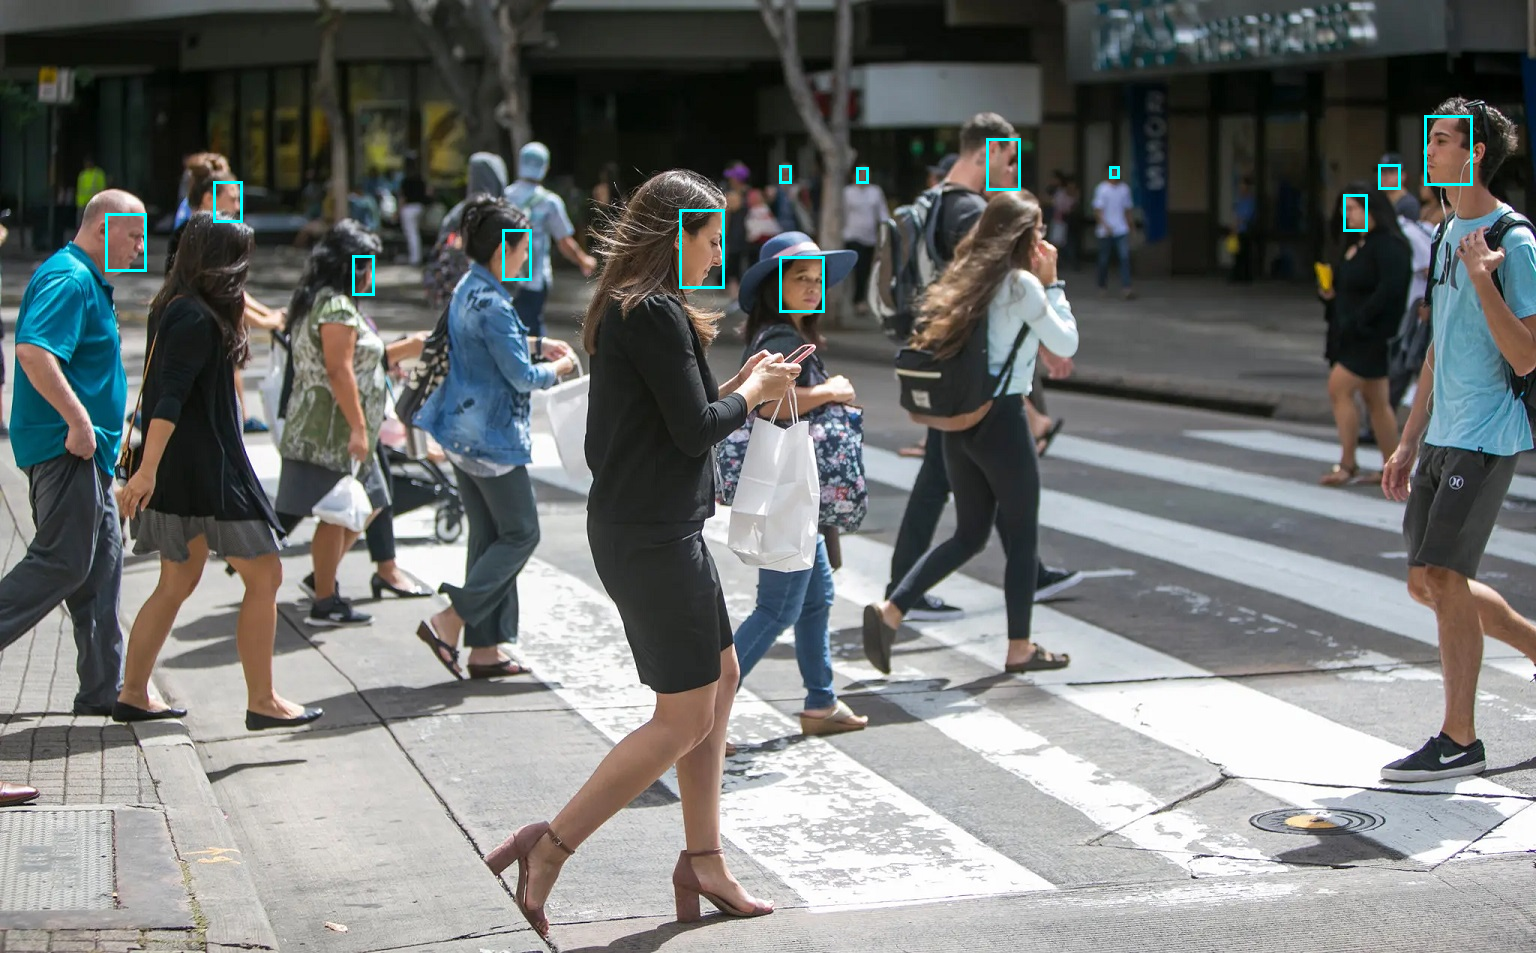

In [14]:
print(f"Detecting faces in {street_scene_image.image_name}...")
faces = street_scene_image.detect_faces()
print(f"Found {len(faces)} faces, here are the first three.")
show_bounding_boxes(
    street_scene_image.image['Bytes'], [[face.bounding_box for face in faces]],
    ['aqua'])

In [16]:
print(f"Detecting labels in {street_scene_image.image_name}...")
labels = street_scene_image.detect_labels(100)
print(f"Found {len(labels)} labels.")
for label in labels:
    pprint(label.to_dict())

Detecting labels in images/imag01.jpg...
Found 13 labels.
{'name': 'Tarmac'}
{'name': 'Asphalt'}
{'name': 'Road'}
{'name': 'Person'}
{'name': 'Human'}
{'name': 'Shoe'}
{'name': 'Clothing'}
{'name': 'Footwear'}
{'name': 'Apparel'}
{'name': 'Pedestrian'}
{'name': 'Zebra Crossing'}
{'name': 'Path'}
{'name': 'Shorts'}


Showing bounding boxes for ['Person', 'Shoe'] in ['aqua', 'red'].


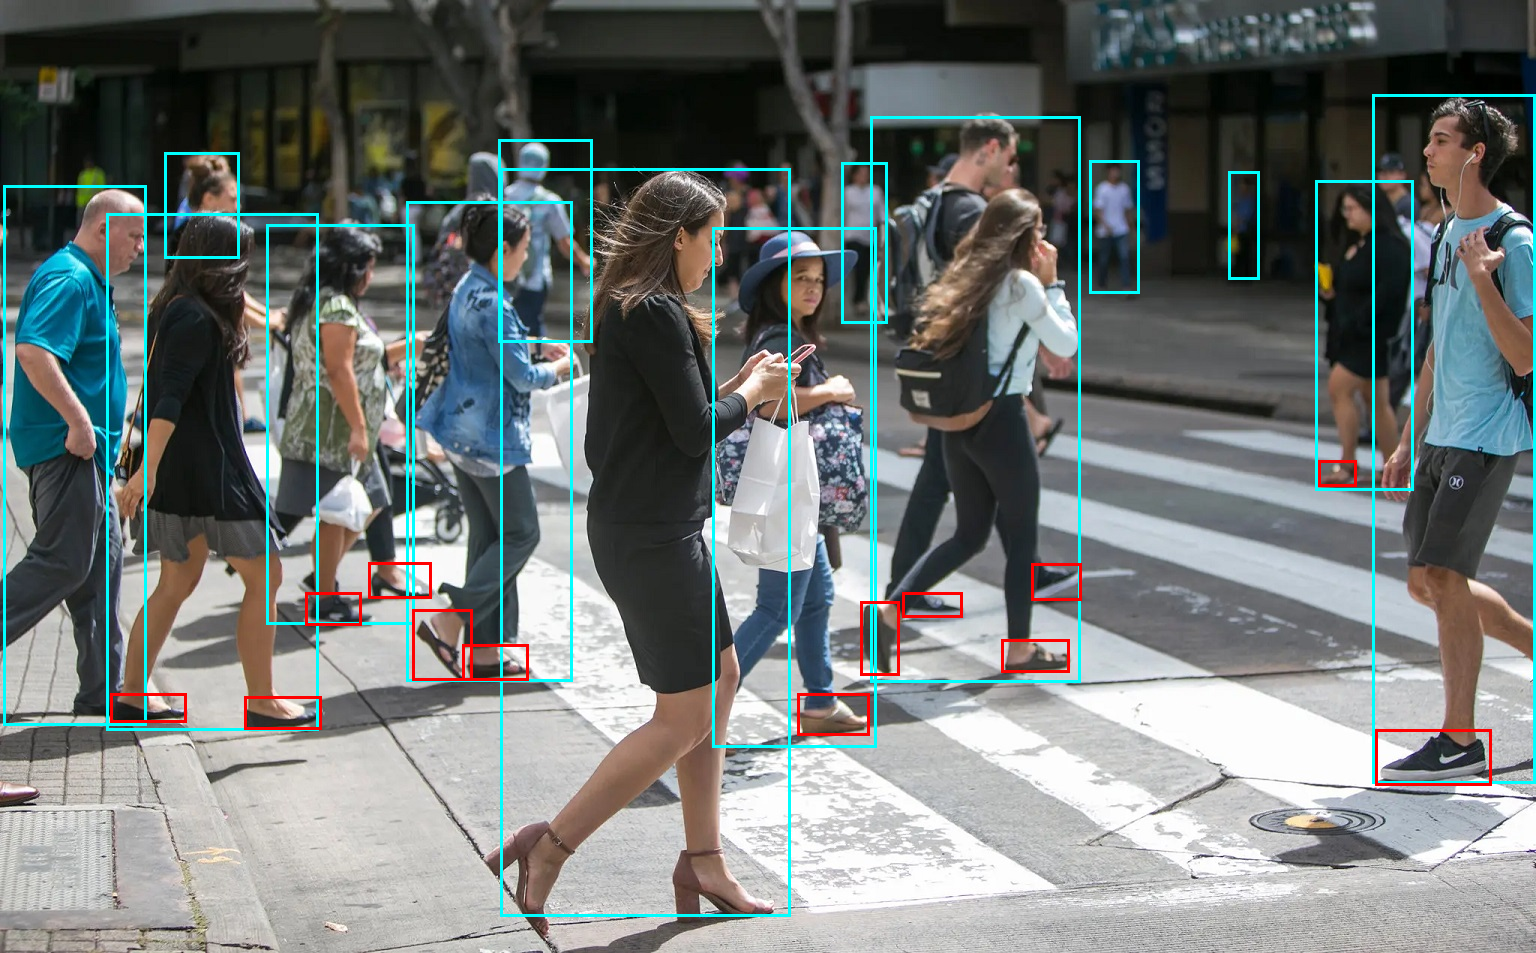

In [17]:
names = []
box_sets = []
colors = ['aqua', 'red', 'white', 'blue', 'yellow', 'green']
for label in labels:
    if label.instances:
        names.append(label.name)
        box_sets.append([inst['BoundingBox'] for inst in label.instances])
print(f"Showing bounding boxes for {names} in {colors[:len(names)]}.")
show_bounding_boxes(
    street_scene_image.image['Bytes'], box_sets, colors[:len(names)])

## Celebrity Rekognition

In [20]:
celebrity_image = RekognitionImage.from_file(
        celebrity_file_name, rekognition_client)

Detecting celebrities in images/imag02.jpg...
Found 3 celebrities.
"Ralph Bellamy - ['CONFUSED']"
"Cary Grant - ['CONFUSED']"
"Rosalind Russell - ['CALM']"


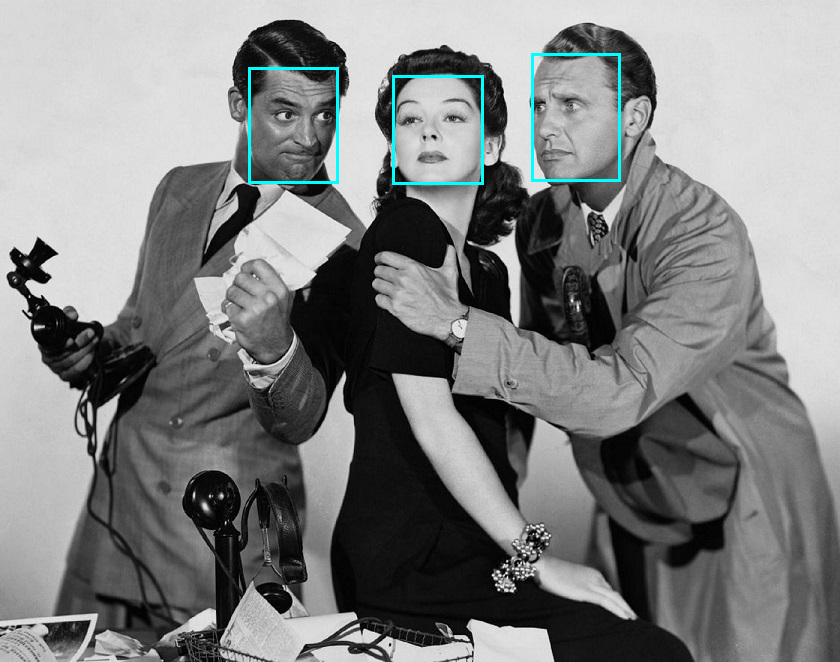

In [31]:
print(f"Detecting celebrities in {celebrity_image.image_name}...")
celebs, others = celebrity_image.recognize_celebrities()
print(f"Found {len(celebs)} celebrities.")
for celeb in celebs:
    pprint(str(celeb.to_dict()['name']) + " - " + 
           str(celeb.to_dict()['emotions']))
show_bounding_boxes(
    celebrity_image.image['Bytes'],
    [[celeb.face.bounding_box for celeb in celebs]], ['aqua'])

## Girl Image

In [37]:
girl_image = RekognitionImage.from_file(
        girl_image_name, rekognition_client)

group_image = RekognitionImage.from_file(
        three_girls_image_name, rekognition_client)

Comparing reference face to group of faces...
Found 1 face matching the reference face.


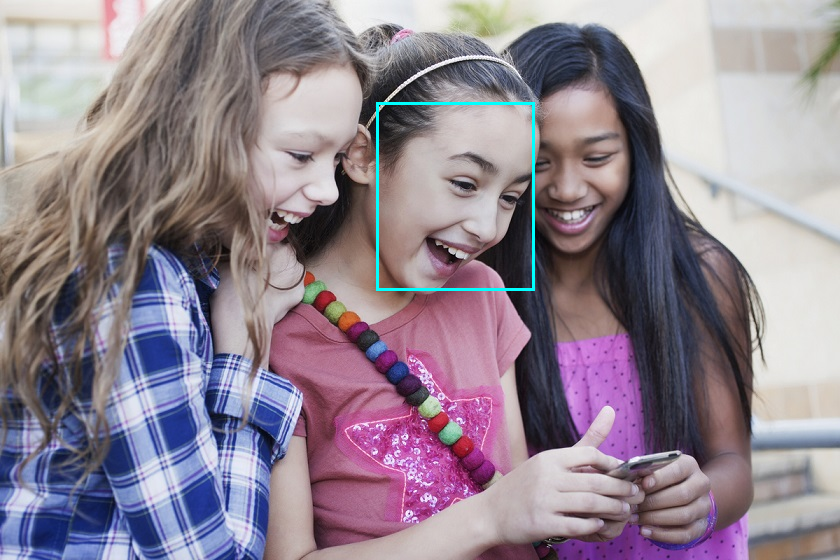

In [38]:
print("Comparing reference face to group of faces...")
matches, unmatches = girl_image.compare_faces(group_image, 80)
print(f"Found {len(matches)} face matching the reference face.")
show_bounding_boxes(
    group_image.image['Bytes'], [[match.bounding_box for match in matches]],
    ['aqua'])

## Detecting suggestive content

In [ ]:
swimwear_image_name = 'images/imag05.jpg'
display(IImage(url=swimwear_image_name ))

In [47]:
swimwear_image = RekognitionImage.from_file(
        swimwear_image_name, rekognition_client)

In [48]:
print(f"Detecting suggestive content in {swimwear_image_name}...")
labels = swimwear_image.detect_moderation_labels()
print(f"Found {len(labels)} moderation labels.")
for label in labels:
    pprint(label.to_dict())

Detecting suggestive content in images/imag05.jpg...
Found 2 moderation labels.
{'name': 'Suggestive', 'parent_name': ''}
{'name': 'Female Swimwear Or Underwear', 'parent_name': 'Suggestive'}


## Detecting text

In [50]:
book_image = RekognitionImage.from_file(book_image_name, rekognition_client)

Detecting text in images/imag06.jpg...
Found 25 text instances. Here are the first seven:
'Efficient Problem Solving with Python'
'Python'
'for Unix and Linux'
'System Administration'
"O'REILLY®"
'Noah Gift & Jeremy M Jones'
'Efficient'


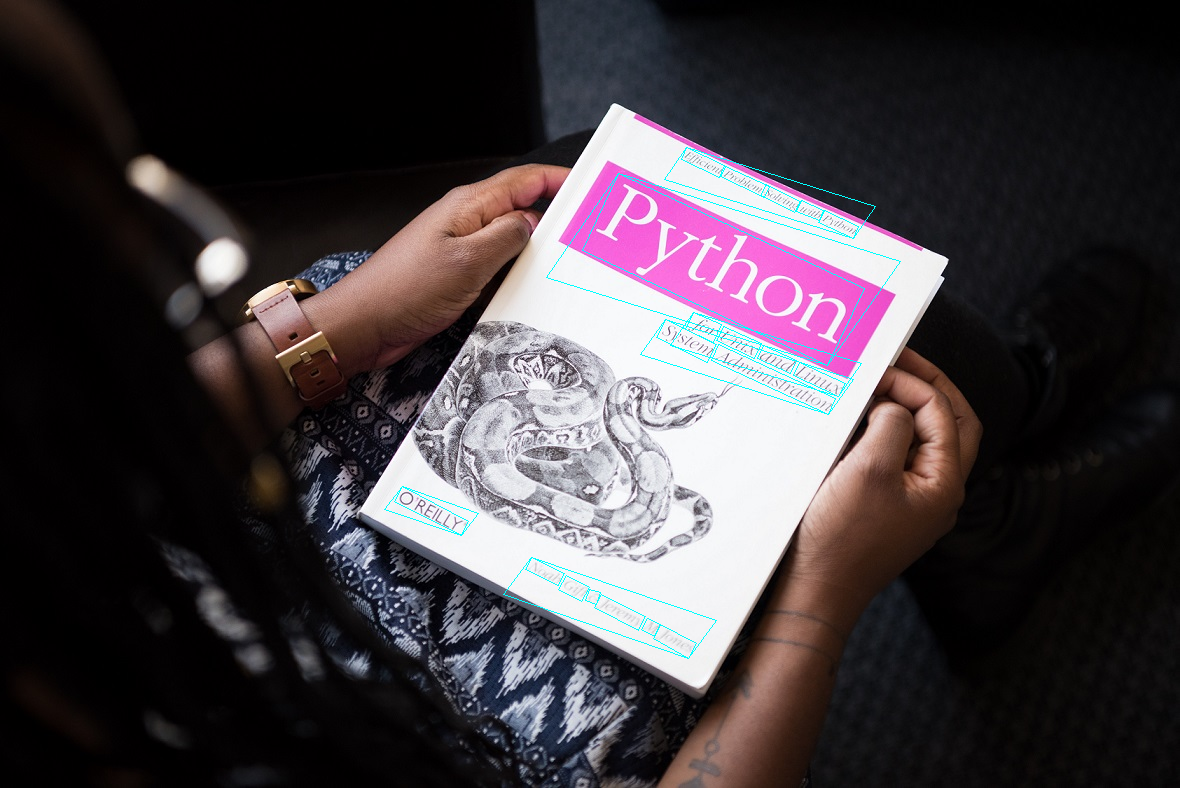

In [54]:
print(f"Detecting text in {book_image.image_name}...")
texts = book_image.detect_text()
print(f"Found {len(texts)} text instances. Here are the first seven:")
for text in texts[:7]:
    pprint(text.to_dict()['text'])
show_polygons(
    book_image.image['Bytes'], [text.geometry['Polygon'] for text in texts], 'aqua')